In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder,MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from sklearn.utils.class_weight import compute_class_weight

import shap # shap value
import joblib # to save model

## A. Exploratory Data Analysis

Column List:  
a. ID: the individual’s patient ID  
b. Registration Date: the individual’s registration date at the hospital  
c. Drug: type of drug given to the individual (D-penicillamine or placebo)  
d. Birth Date: the birth date of the individual  
e. Gender: the gender of the individual  
f. Ascites: presence of ascites (Y/N)  
g. Hepatomegaly: presence of hepatomegaly (Y/N)  
h. Edema: presence of edema (N = no edema, S = edema without diuretics, Y = edema despite diuretic therapy)  
i. Bilirubin: serum bilirubin (mg/dL)  
j. Cholesterol: serum cholesterol (mg/dL)  
k. Albumin: amount of albumin (g/dL)  
l. Copper: amount of copper found in urine (μg/day)  
m. Alkaline Phospatase (U/L): alkaline phosphatase (U/L)  
n. SGOT: Serum Glutamic-Oxaloacetic Transaminase (U/mL)  
o. Tryglicerides: Amount of triglycerides (mg/dL)  
p. Platelets: Platelets per cubic (mL/1000)  
q. Prothrombin: Prothrombin time (s)  
r. Stage: Histologic stage of the cirrhosis  

In [51]:
df = pd.read_csv('1A.tsv', delimiter = '\t')
df

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,2023/01/30,NaN,1957/12/11,F,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,-1.0,174.0,10.9,stage_3
414,415,2021/12/04,NaN,1985/12/11,F,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,-1.0,180.0,11.2,Stage4
415,416,2022/01/21,NaN,1967/12/12,F,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,-1.0,143.0,9.9,stage_3
416,417,2023/01/20,NaN,1966/12/11,F,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,-1.0,269.0,10.4,stage_3


In [52]:
# Remove duplicate data
df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)

In [53]:
# Remove identifier
df = df.drop(columns=['ID', 'Registration Date'])
df.head()

,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


ID and registration date is not relevant for the cirrhosis model, so we drop the column

In [54]:
# Check missing value
missingValue = df.isnull().sum()
missingValue

Drug                         106
Birth Date                     0
Gender                         0
Ascites                      106
Hepatomegaly                 106
Edema                          0
Bilirubin                      0
Cholesterol                  338
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                  0
Platelets                     11
Prothrombin                    2
Stage                          6
dtype: int64

There's so many missing value in Cholesterol Column, 80.8% of Cholesterol data is missing. If we impute 80% of the data, it will make almost the entire data into synthetic data. To maintain the natural data, we can't impute. Also, we don't want to drop 80% of the data, because it's such a waste of resource. So, for this cirrhosis early screening model, we drop the cholesterol column. Later, if we have better data, the model can be improved.  
For others missing value, it's around 25.8% of total data, it will be bad too if we impute missing value. So, we drop the missing value for others column.

In [55]:
# Drop cholesterol column
df = df.drop(columns=['Cholesterol'])

# Drop missing value
df = df.dropna().reset_index(drop=True)
missingValue = df.isnull().sum()
print(missingValue)

df

Drug                         0
Birth Date                   0
Gender                       0
Ascites                      0
Hepatomegaly                 0
Edema                        0
Bilirubin                    0
Albumin                      0
Copper                       0
Alkaline Phospatase (U/L)    0
SGOT                         0
Tryglicerides                0
Platelets                    0
Prothrombin                  0
Stage                        0
dtype: int64


,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,D-penicillamine,1968/07/01,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,D-penicillamine,1954/11/15,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,D-penicillamine,1970/03/16,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,Placebo,1986/11/03,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,D-penicillamine,1963/10/06,F,N,Y,N,0.4,3.58,24.0,797.0,91.00,113.0,288.0,10.4,Stage 2
302,Placebo,1966/08/24,F,N,N,N,0.4,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,Stage 2
303,D-penicillamine,1962/08/12,F,N,N,N,1.7,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,Stage 2
304,D-penicillamine,1986/12/12,F,N,N,N,2.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,Stage 2


After dropping the missing value, the total of remaining data is 306 row.

In [56]:
# Select Categorical dan Numerical Column
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['Drug', 'Birth Date', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
Numeric: ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


Birth Date cannot be encoded to be numeric, so it is better to convert Birth Date into a more useful variable, which is Age.

In [57]:
# Change Birth Date to Age
df['Birth Date'] = pd.to_datetime(df['Birth Date'], format='%Y/%m/%d')

# Calculate Age
current_date = datetime.now()
df['Age'] = df['Birth Date'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))
df = df.drop(columns = ['Birth Date'])

# Input Age to Numeric
num_cols.append('Age')
cat_cols.remove('Birth Date')

df

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,58
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,56
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,70
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4,54
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,D-penicillamine,F,N,Y,N,0.4,3.58,24.0,797.0,91.00,113.0,288.0,10.4,Stage 2,61
302,Placebo,F,N,N,N,0.4,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,Stage 2,58
303,D-penicillamine,F,N,N,N,1.7,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,Stage 2,62
304,D-penicillamine,F,N,N,N,2.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,Stage 2,38


In [58]:
# Univariate analysis (mode)
for i in cat_cols:
    print(df[i].value_counts(),'\n')


Drug
D-penicillamine    152
Placebo            149
d-penicillamine      3
placebo              1
lacebo               1
Name: count, dtype: int64 

Gender
F    271
M     35
Name: count, dtype: int64 

Ascites
N    283
Y     23
Name: count, dtype: int64 

Hepatomegaly
Y    156
N    150
Name: count, dtype: int64 

Edema
N    258
S     28
Y     20
Name: count, dtype: int64 

Stage
stage_3    118
Stage4     108
Stage 2     65
Stage 1     15
Name: count, dtype: int64 



There's some inconsistency in the categorical data, in Drug column, theres some typo data like lacebo and inconsistent typing of Placebo and D-penicillamine.  
Also, in Stage column, the value is not consistent, there's 'stage_3' , 'Stage4', and 'Stage 1'. It'll affect the encoding, so Drug and Stage need special treatment  
  
Other than that, the Stage column (model's target), has an uneven distribution of data, where Stage 1 only has 15 data or only about 5% of the total data. This small amount of data in Stage 1 can make it difficult for the model to learn Stage 1. However, the models for Cirrhosis early screening are Random Forest and XGBoost which are quite resistant to imbalance data so there is no need for oversampling of Stage 1 data.

In [59]:
# Fix the inconsistent value
correction = {
    'lacebo' : 'Placebo',
    'placebo' : 'Placebo',
    'd-penicillamine' : 'D-penicillamine',
    'stage_3' : 'Stage 3',
    'Stage4' : 'Stage 4'
}

df['Drug'] = df['Drug'].replace(correction)
df['Stage'] = df['Stage'].replace(correction)

df['Drug'].value_counts()

Drug
D-penicillamine    155
Placebo            151
Name: count, dtype: int64

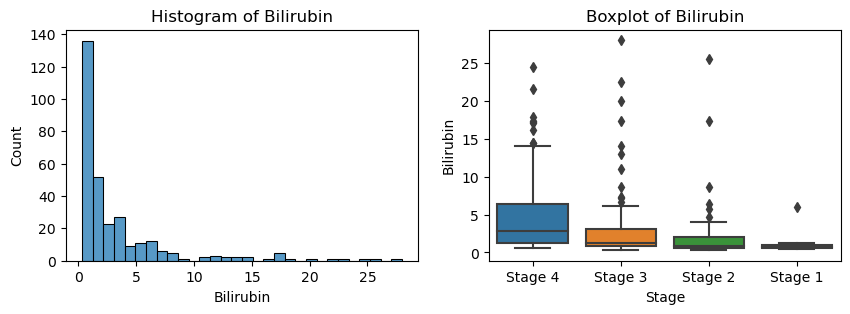

Bilirubin - Skewness: 2.817540214492091
Bilirubin - Kurtosis: 8.680667490516994


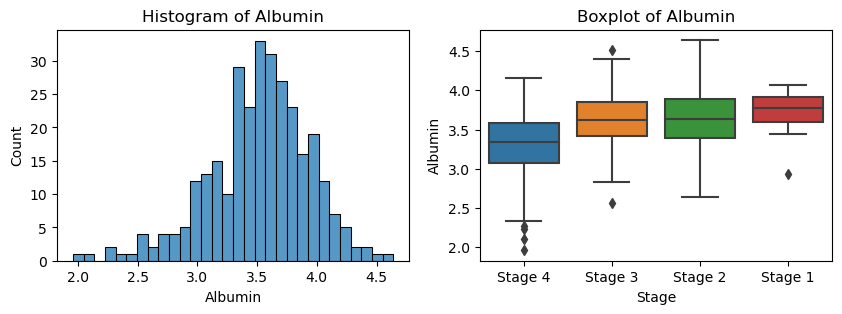

Albumin - Skewness: -0.5782674450898165
Albumin - Kurtosis: 0.9638761384912069


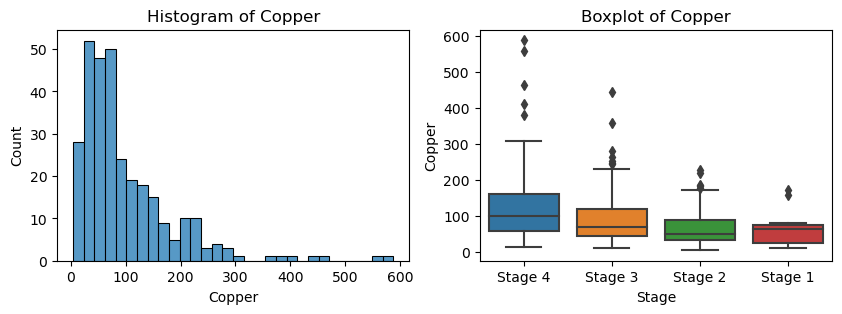

Copper - Skewness: 2.2856431823652814
Copper - Kurtosis: 7.515563507128517


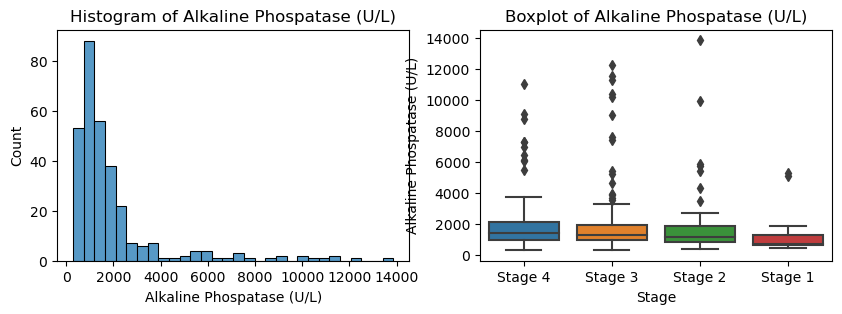

Alkaline Phospatase (U/L) - Skewness: 3.005139813159215
Alkaline Phospatase (U/L) - Kurtosis: 9.723126571888724


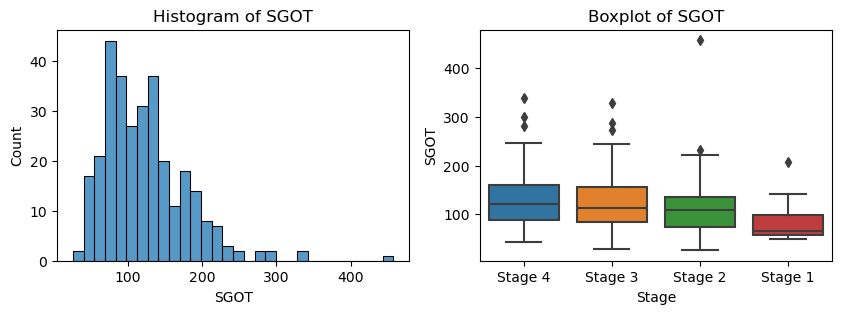

SGOT - Skewness: 1.4474186250483927
SGOT - Kurtosis: 4.289812936450611


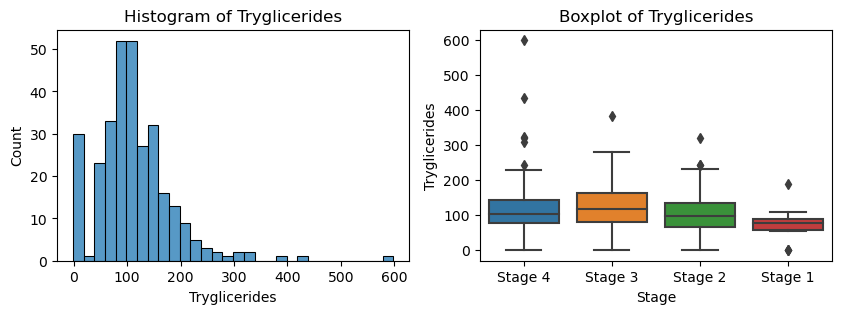

Tryglicerides - Skewness: 1.673768524651463
Tryglicerides - Kurtosis: 7.7356324734000665


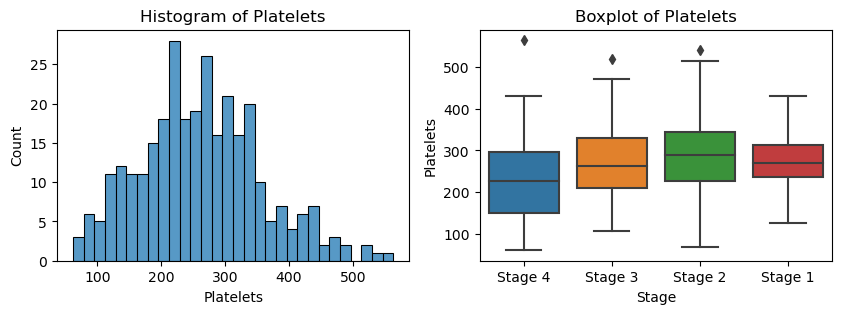

Platelets - Skewness: 0.3734854844035126
Platelets - Kurtosis: -0.005941626677032907


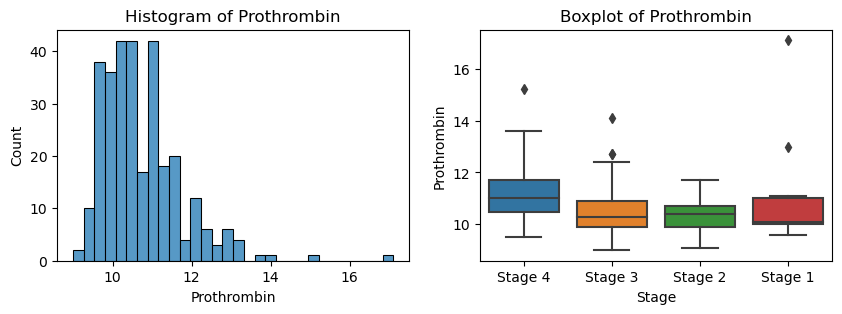

Prothrombin - Skewness: 1.7392944630320002
Prothrombin - Kurtosis: 6.018483343031384


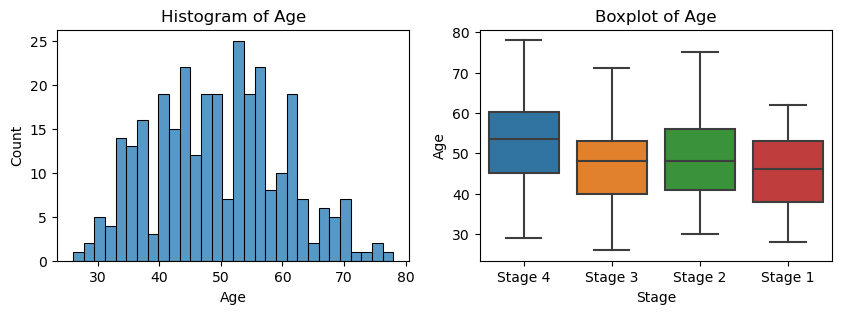

Age - Skewness: 0.1737473169839306
Age - Kurtosis: -0.5129629767103787


In [60]:
# Check outlier and distribution
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30)
        plt.title(f'Histogram of {col}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x = 'Stage', y=col, data=dataframe)
        plt.title(f'Boxplot of {col}')
        
        plt.show()

        print(f'{col} - Skewness: {dataframe[col].skew()}')
        print(f'{col} - Kurtosis: {dataframe[col].kurt()}')
        
check_distribution_outliers(df[num_cols + ['Stage']], num_cols)

Based on the graph above, it can be seen that all numerical columns are not normally distributed (visually), and almost all numerical columns have some outliers, only the Age column has no outliers. However, in this data, outliers are not a bad thing so they do not need to be removed and used anyway.  
For further confidence in the normal distribution, we need to perform the Shapiro test for more precise results.

Visually, it can be seen that there are differences in the distribution of data in the numerical column between different stages. One of the visible patterns is Copper, where the Q3 and Q1 values continue to decrease between Stage 4 until Stage 1. Furthermore, ANOVA/Kruskal-Wallis test is needed to determine the variables whose values are significantly different between different stages.

In [61]:
# check distribution
for i in num_cols:
    print(i, shapiro(df[i]))

Bilirubin ShapiroResult(statistic=0.626072883605957, pvalue=2.651746072139116e-25)
Albumin ShapiroResult(statistic=0.9797792434692383, pvalue=0.0002575731778051704)
Copper ShapiroResult(statistic=0.790023922920227, pvalue=1.4634368244893354e-19)
Alkaline Phospatase (U/L) ShapiroResult(statistic=0.6123024225234985, pvalue=1.0898550976911643e-25)
SGOT ShapiroResult(statistic=0.9120213985443115, pvalue=2.141211036602031e-12)
Tryglicerides ShapiroResult(statistic=0.8889103531837463, pvalue=3.843880576792809e-14)
Platelets ShapiroResult(statistic=0.9880037307739258, pvalue=0.012351727113127708)
Prothrombin ShapiroResult(statistic=0.8831713199615479, pvalue=1.5519903477602057e-14)
Age ShapiroResult(statistic=0.9891638159751892, pvalue=0.022372573614120483)


Based on the p value of the Shapiro test, where all p values are <0.05, it can be seen that all numerical columns are indeed not normally distributed. So, we must avoid analysis/methods that are sensitive to mean and standard deviation. For scaling, I would use robust scaler for all of the numerical columns. Also, we avoid ANOVA test and use Kruskal-Wallis test.

In [62]:
# Bivariate analysis with Kruskal-Wallis
kruskal_results = {}
for col in num_cols:
    stage_1_group = df[df['Stage'] == 'Stage 1'][col]
    stage_2_group = df[df['Stage'] == 'Stage 2'][col]
    stage_3_group = df[df['Stage'] == 'Stage 3'][col]
    stage_4_group = df[df['Stage'] == 'Stage 4'][col]
    
    h_val, p_val = stats.kruskal(
        stage_1_group.dropna(),
        stage_2_group.dropna(),
        stage_3_group.dropna(),
        stage_4_group.dropna()
    )
    
    kruskal_results[col] = p_val

kruskal_results

{'Bilirubin': 8.277495686007208e-10,
 'Albumin': 2.022908614422319e-09,
 'Copper': 5.857719935297335e-06,
 'Alkaline Phospatase (U/L)': 0.023687274909546266,
 'SGOT': 0.0025032730918568133,
 'Tryglicerides': 0.0029092787097336065,
 'Platelets': 0.00011191943568828017,
 'Prothrombin': 8.250920992041131e-09,
 'Age': 0.002765945126193013}

Based on the results of the Kruskal-Wallis test, all of the numerical columns have a p value < 0.05, which means that there is a significant association between the independent variable, in this case all numerical columns, to the dependent variable (Stage).

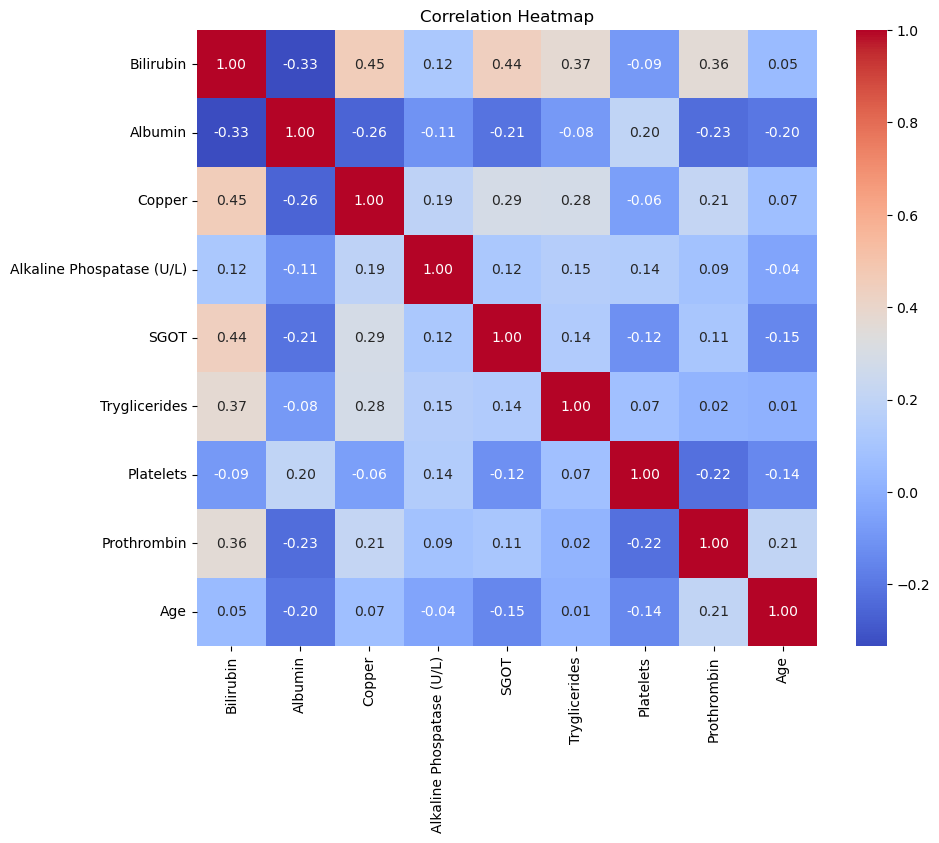

In [63]:
# Check correlation
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Based on the correlation heatmap, there is no high correlation between the numerical columns in the data, so there are no columns that strongly affect each other.

### EDA Summary
Based on the EDA that has been done:
- There are a lot of missing values in the data, especially in the Cholesterol column where 80.8% of the data are missing values, so the Cholesterol column is removed for this model development. Furthermore, if there is an improvement in the data, then the Cholesterol column can be used. Besides the Cholesterol column, there are about 108 missing values in some columns or about 25.8% of the total data, so the data needs to be discarded to maintain accurate data. The initial 418 data was reduced to 306 data after taking care of the missing values.

- The Birth Date column has been changed to a new column, Age, so that it can be processed and is more useful for the model.

- There's inconsistent value in some categorical column

- The data in the Stage column is considered imbalanced data, as Stage 4 has 108 data, Stage 3 has 118 data, Stage 2 has 65 data, and Stage 1 has only 15 data. Oversampling is not performed because the XGBoost and Random Forest models are quite resistant to imbalanced data and oversampling can lead to new issues related to synthetic data.

- All numerical columns are not normally distributed, so avoid analysis that is sensitive to mean or standard deviation.

- Based on kruskal test, all numerical columns have significant effect on Stage (target) column. 

## Preprocessing

### Split Data

In [64]:
# Spliting data
x = df[df.columns.drop(['Stage'])]
y = df['Stage']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

### Encoding

List of categorical column:
1. Drug: type of drug given to the individual (D-penicillamine or placebo)
2. Gender: the gender of the individual (F/M)  
3. Ascites: presence of ascites (Y/N)  
4. Hepatomegaly: presence of hepatomegaly (Y/N)  
5. Edema: presence of edema (N = no edema, S = edema without diuretics, Y = edema despite diuretic therapy)

In [65]:
lab_enc = LabelEncoder()

label_column = ['Drug', 'Gender', 'Ascites', 'Hepatomegaly']
for i in label_column:
    x_train[i] = lab_enc.fit_transform(x_train[[i]])
    x_test[i] = lab_enc.transform(x_test[[i]])

c:\Users\hense\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

In [66]:
# Ordinal encoding for edema
categories_order = [['N', 'S', 'Y']]
ord_enc = OrdinalEncoder(categories=categories_order)

x_train['Edema'] = ord_enc.fit_transform(x_train[['Edema']])
x_test['Edema'] = ord_enc.transform(x_test[['Edema']])

In [67]:
# Ordinal encoding for Stage
categories_order = [['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']]
ord_enc = OrdinalEncoder(categories=categories_order)

y_train = ord_enc.fit_transform(y_train.to_frame())
y_test = ord_enc.transform(y_test.to_frame())

y_train = y_train.ravel()
y_test = y_test.ravel()

### Scaling

In [68]:
rob_scaler = RobustScaler()

x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

## B. Train Model

### Random Forest

In [69]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_features=3, random_state=42)

# Train the model
rf_model.fit(x_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(x_test)

In [70]:
# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.46774193548387094
Confusion Matrix:
[[ 0  0  3  0]
 [ 0  0 13  2]
 [ 0  1 12  4]
 [ 0  1  9 17]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00        15
         2.0       0.32      0.71      0.44        17
         3.0       0.74      0.63      0.68        27

    accuracy                           0.47        62
   macro avg       0.27      0.33      0.28        62
weighted avg       0.41      0.47      0.42        62



c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine Tuning Random Forest

In [71]:
# Grid hyperparameter
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon
    'max_depth': [None, 10, 20, 30],  # Kedalaman maksimum setiap pohon
    'max_features': [3, 5, 'sqrt'],   # Fitur maksimum untuk split
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],    # Minimum sampel per daun
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Penyesuaian bobot kelas
}

# Initial model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',  
    n_jobs=-1,  
    verbose=2   
)

In [72]:
# Fit GridSearchCV pada data train
grid_search.fit(x_train, y_train)

# Best Parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.5004949602318024


### Evaluation Random Forest

In [73]:
# Best Model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predict dataset
rf_predictions = best_rf_model.predict(x_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

# Classification report
print(classification_report(y_test, rf_predictions))

# Matthew's Correlation Coefficient (MCC)
mcc1 = matthews_corrcoef(y_test, rf_predictions)
print("MCC Score:", mcc1)

Confusion Matrix:
[[ 0  2  1  0]
 [ 0  4  9  2]
 [ 1  4  6  6]
 [ 0  0 11 16]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.40      0.27      0.32        15
         2.0       0.22      0.35      0.27        17
         3.0       0.67      0.59      0.63        27

    accuracy                           0.42        62
   macro avg       0.32      0.30      0.31        62
weighted avg       0.45      0.42      0.43        62

MCC Score: 0.14002588114196118


Based on the confusion matrix, in the 'Stage 1' class, the random forest model can't predict correctly at all, the model only predicts 1 data as 'Stage 1' which is actually 'Stage 3', possibly due to the lack of data due to imbalanced data. In 'Stage 2', the model only managed to predict 4 correct 'Stage 2' data, most of the 'Stage 2' data was predicted by the model to be 'Stage 3'. In 'Stage 3', the model successfully predicted 6 data correctly, but the model mostly incorrectly predicted 'Stage 3', where there were 9 'Stage 2' data and 11 'Stage 4' data predicted to be 'Stage 3'. It can be said that the model tends to predict a lot of data into 'Stage 3' which makes low precision value at 'Stage 3'. Finally, at 'Stage 4', the model's performance is better than the other stages, but still not good enough, where there are 16 correct predictions. However, there are 11 'Stage 4' data that are instead predicted to be 'Stage 3'.

Based on the Classification report, by macro (without considering the amount of data in each class), the model has a precision score of 0.32 or 32% of the predictions made by the model are correct predictions. Then, the recall score is 0.30 or 30% of the data that is actually positive, is correctly predicted by the model. This makes the f1-score or combined score of the model's precision and recall to be 0.31. In this case, recall score is more important than precision because we don't want people get a wrong prediction, especially the model tends to predict 'Stage 2' and 'Stage 4' data to be 'Stage 3'. This result is still very far from being good, and it can be concluded that the model's performance is not good enough. 

Lastly, Matthew's Correlation Coefficient, which is a metric to measure the strength of the relationship between the model's prediction and the actual label on unbalanced data. The MCC score of the model is 0.14, which means that the predictions made by the model are poor, because getting closer to 0 means that the model makes predictions that tend to be random. A good MCC score is the one that is close to +1.

It can be concluded that the model is not yet qualified to be used as early screening, because only 32% of the model predictions are correct and 30% of actual data is correctly predicted by model, which is only slightly better than random guessing (25% chance). The MCC value also indicates that the model is close to random predictions.

### XGBoost

In [74]:
# Create the XGBoost model
xg_model = xgb.XGBClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 6, eval_metric='mlogloss', random_state=123)

# Train the model
xg_model.fit(x_train, y_train)

# Predict on the test set
xg_predictions = xg_model.predict(x_test)

In [75]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, xg_predictions))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, xg_predictions))

Confusion Matrix:
[[ 0  2  1  0]
 [ 0  2 11  2]
 [ 0  4  9  4]
 [ 0  0  9 18]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.25      0.13      0.17        15
         2.0       0.30      0.53      0.38        17
         3.0       0.75      0.67      0.71        27

    accuracy                           0.47        62
   macro avg       0.33      0.33      0.32        62
weighted avg       0.47      0.47      0.45        62



c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine Tuning XGBoost

In [76]:
xg_model = xgb.XGBClassifier(random_state=123, eval_metric='mlogloss')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5],
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    scoring='f1_macro', 
    cv=5,  
    verbose=2,
    n_jobs=-1
)

In [77]:
# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Get the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100}
Best Score: 0.4892616690715396


### Evaluating XGBoost

In [78]:
# Use the best estimator for predictions
best_model = grid_search.best_estimator_
xg_predictions = best_model.predict(x_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, xg_predictions))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, xg_predictions))

# Matthew's Correlation Coefficient (MCC)
mcc2 = matthews_corrcoef(y_test, xg_predictions)
print("MCC Score:", mcc2)

Confusion Matrix:
[[ 0  0  2  1]
 [ 0  2 10  3]
 [ 0  2  8  7]
 [ 0  1 11 15]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.40      0.13      0.20        15
         2.0       0.26      0.47      0.33        17
         3.0       0.58      0.56      0.57        27

    accuracy                           0.40        62
   macro avg       0.31      0.29      0.27        62
weighted avg       0.42      0.40      0.39        62

MCC Score: 0.10344041050434823


c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hense\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the confusion matrix, in the 'Stage 1' class, the random forest model also can't predict correctly at all, the model does not predict any of the data as 'Stage 1'. For 'Stage 2', the model only managed to predict 2 correct 'Stage 2' data, most of the 'Stage 2' data was predicted by the model to be 'Stage 3'. In 'Stage 3', the model successfully predicted 8 data correctly, but the model mostly incorrectly predicted 'Stage 3', where there were 10 'Stage 2' data and 11 'Stage 4' data predicted to be 'Stage 3'. It can be said that the model tends to predict a lot of data into 'Stage 3' which makes low precision value at 'Stage 3'. Finally, at 'Stage 4', the model's performance is better than the other stages, but still not good enough, where there are 15 correct predictions and 11 wrong 'Stage 4' predictions. However, there are 11 'Stage 4' data that are instead predicted to be 'Stage 3'.

Based on the Classification report, by macro (without considering the amount of data in each class), the model has a precision score of 0.31 or 31% of the predictions made by the model are correct predictions. Then, the recall score is 0.29 or 29% of the data that is actually true, is correctly predicted by the model. This makes the f1-score or combined score of the model's precision and recall to be 0.27. In this case, recall score is more important than precision because we don't want people get a wrong prediction, especially the model tends to predict 'Stage 2' and 'Stage 4' data to be 'Stage 3'. This result is still very far from being good, and the performance of the XGBoost model is not as good as the performance of the Random Forest model, which is also not considered good. 

Lastly, Matthew's Correlation Coefficient, the MCC score of the XGBoost model is 0.103, which is lower than Random Forest model, it means that the predictions made by the XGBoost model are worse, because getting closer to 0 means that the model makes predictions that tend to be random.

It can be concluded that the model is not yet qualified to be used as early screening, because only 31% of the model predictions are correct and only 29% of the actual data is correctly predicted by the model, which is only slightly better than random guessing (25% chance). The MCC value also indicates that the model is close to random predictions.

## D. Important Features (Shap)

PermutationExplainer explainer: 63it [00:18,  1.55it/s]                        


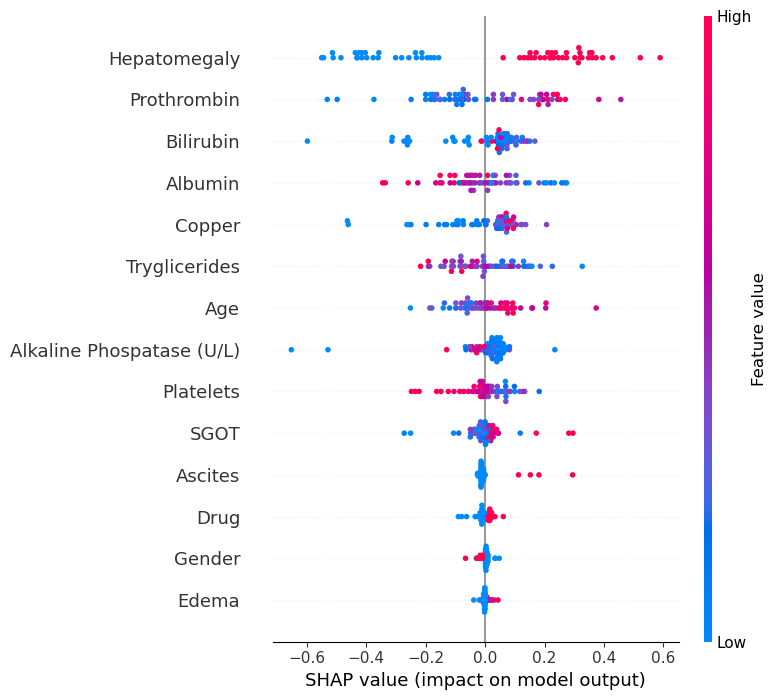

In [79]:
joblib.dump(best_rf_model, 'model.pkl')

loaded_model = joblib.load('model.pkl')

# SHAP Explainer
# Define a predict function
def predict_fn(X):
    return loaded_model.predict(X)

# SHAP Explainer
explainer = shap.Explainer(predict_fn, x_test)
shap_values = explainer(x_test)


shap.summary_plot(shap_values, x_test)

Between the two models above, that is, Random Forest and XGBoost model, the model that has a slightly better performance is Random Forest. If the Random Forest model is analyzed, the features that are important in the model to predict the output are in the order in the figure above, here are the 5 most important features in the best model:  
1. Hepatomegaly, this feature has the highest impact in the model, where the higher the value of Hepatomegaly (1 or Y) will increase the prediction of the model in a certain direction, and conversely, the lower the value of Hepatomegaly (0 or N) will decrease the prediction of the model in a certain direction.
2. Prothrombin, is the second most important feature that affects the prediction of the model, the higher the value of Prothrombin will increase the prediction of the model in a certain direction and vice versa.
3. Albumin, in this feature, the impact is inversely proportional to the model prediction, where the higher the Albumin value, the lower the model prediction in a certain direction, and the lower it will increase the model prediction in a certain direction.
4. Bilirubin, this feature is interesting because what tends to have more impact on predictions is small Bilirubin values, where small Bilirubin values can reduce model predictions in a certain direction, and large Bilirubin values slightly increase model predictions in a certain direction.
5. Copper, the copper feature is the same as Bilirubin, where the value that has more impact is the small Copper value, where the small Copper value can reduce the model prediction, and the high Copper value tends to slightly increase the model prediction in a certain direction.